The University of Tokyo  
Special Lectures in Information Science Ⅱ  
Introduction to Near-Term Quantum Computing  
# 8. Classical Simulation
Yoshiaki Kawase (Jun 07, 2024)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import qiskit
qiskit.__version__

'1.0.2'

In [3]:
import numpy as np
import math
import random

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

#from qiskit_ibm_runtime import QiskitRuntimeService
#service = QiskitRuntimeService()
#backend = service.get_backend("simulator_mps")

## Matrix Product State simulator

First, we will use the Matrix Prodcut State simulator to see how it works.

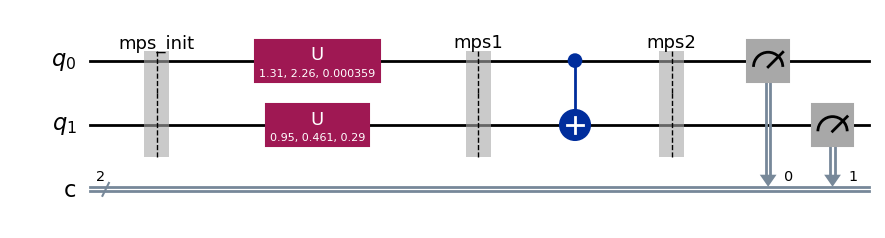

In [4]:
mps_simulator = AerSimulator(method='matrix_product_state')
n_qubits=2
seed = 1
np.random.seed(seed)
random.seed(seed)
angles = np.random.rand(9)*math.pi

qc = QuantumCircuit(n_qubits, n_qubits)
qc.save_matrix_product_state(label='mps_init')
qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state
qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state
qc.save_matrix_product_state(label='mps1')
qc.cx(0,1)
qc.save_matrix_product_state(label='mps2')
qc.measure(range(n_qubits), range(n_qubits))
qc.draw(output="mpl")

In [5]:
tqc = transpile(qc, mps_simulator)
result = mps_simulator.run(tqc).result()
result.data(0)['mps_init']

([(array([[1.+0.j]]), array([[0.+0.j]])),
  (array([[1.+0.j]]), array([[0.+0.j]]))],
 [array([1.])])

From the output of the simulator, the initial state $|00\rangle$ is described by
$ |\psi_{init}\rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$, 
where $A^{0} = 1, A^{1}=0, B^{0}=1, B^{1}=0, \lambda=1$. 

In [6]:
A0 = 1
A1 = 0
B0 = 1
B1 = 0

Next, we act unitary gate U on 0-th qubit. An unitary gate can be described by $2 \times 2$ matrix

$U=
\begin{pmatrix}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{pmatrix}
=u_{00} |0\rangle \langle 0|+u_{01} |0\rangle \langle 1|+u_{10} |1\rangle \langle 0|+u_{11} |1\rangle \langle 1|$.

$(U\otimes I)|\psi_{init} \rangle = \bigg( ( A^{0}u_{00} + A^{1}u_{01} )|0\rangle + (A^{0}u_{10} + A^{1}u_{11} ) |1\rangle \bigg) \otimes \sum_{\sigma_1} B^{\sigma_1} |\sigma_1 \rangle$

From the definition of U gate in qiskit, 

$U(\theta_1,\theta_2,\theta_3)=
\begin{pmatrix}
\cos{(\theta_1/2)} & -e^{i\theta_3}\sin{(\theta_1/2)} \\
e^{i\theta_2}\sin{(\theta_1/2)} & e^{i(\theta_2+\theta_3)} \cos{(\theta_1/2)}
\end{pmatrix}
$

In [7]:
# From the definition of U gate in qiskit, 
u00 = np.cos(angles[0]/2)
u01 = -np.exp(1.0j*angles[2])*np.sin(angles[0]/2)
u10 = np.exp(1.0j*angles[1])*np.sin(angles[0]/2)
u11 = np.exp(1.0j*(angles[1]+angles[2]))*np.cos(angles[0]/2)
print( "new A^0=", A0*u00+A1*u01, "new A^1=", A0*u10+A1*u11)

new A^0= (0.7930134282051604+0j) new A^1= (-0.3887996598361402+0.4690037603235188j)


Similarly, we calculate $B^0$ and $B^1$: 

In [8]:
# From the definition of U gate, 
v00 = np.cos(angles[3]/2)
v01 = -np.exp(1.0j*angles[5])*np.sin(angles[3]/2)
v10 = np.exp(1.0j*angles[4])*np.sin(angles[3]/2)
v11 = np.exp(1.0j*(angles[4]+angles[5]))*np.cos(angles[3]/2)
print( "new B^0=", B0*v00+B1*u01, "new B^1=", B0*v10+B1*v11)

new B^0= (0.8893371274812134+0j) new B^1= (0.4095090690923406+0.20342516072155026j)


In [9]:
result.data(0)['mps1']

([(array([[0.79301343+0.j]]), array([[-0.38879966+0.46900376j]])),
  (array([[0.88933713+0.j]]), array([[0.40950907+0.20342516j]]))],
 [array([1.])])

$ |\psi_1 \rangle = \sum_{\sigma_0,\sigma_1} A^{\sigma_0} \lambda B^{\sigma_1} |\sigma_0 \sigma_1 \rangle$, 
where 

In [10]:
print("A^0=", result.data(0)['mps1'][0][0][0][0], ", A^1=", result.data(0)['mps1'][0][0][1][0], 
      "\nB^0=", result.data(0)['mps1'][0][1][0][0], ", B^1=", result.data(0)['mps1'][0][1][1][0],
      "\nlambda=", result.data(0)['mps1'][1][0])

A^0= [0.79301343+0.j] , A^1= [-0.38879966+0.46900376j] 
B^0= [0.88933713+0.j] , B^1= [0.40950907+0.20342516j] 
lambda= [1.]


We can see that the results are consistent with the above calculations.

In [11]:
A0 = result.data(0)['mps1'][0][0][0][0][0]
A1 = result.data(0)['mps1'][0][0][1][0][0]
B0 = result.data(0)['mps1'][0][1][0][0][0]
B1 = result.data(0)['mps1'][0][1][1][0][0]
print(A0, A1, B0, B1)

(0.7930134282051604+0j) (-0.3887996598361402+0.4690037603235188j) (0.8893371274812134+0j) (0.4095090690923406+0.20342516072155026j)


CNOT gate is described by
$CX_{c,t} = |0_c\rangle \langle 0_c| \otimes I_t + |1_c\rangle \langle 1_c| \otimes X_t$. 
If we apply $CX_{0,1}$ to $|\psi_1 \rangle$, 

$|\psi_2 \rangle := CX_{0,1} |\psi_1\rangle= 
(|0\rangle \langle 0| \otimes I + |1\rangle \langle 1| \otimes X)
(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^0|10\rangle+A^1 B^1|11\rangle)$

$=(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^1|10\rangle+A^1 B^0|11\rangle)$

We will decompose $(A^0 B^0|00\rangle+A^0 B^1 |01\rangle+A^1 B^1|10\rangle+A^1 B^0|11\rangle)$ using SVD. 

Here, we consider $|\psi\rangle = c_{00} |00\rangle + c_{01} |01\rangle + c_{10} |10\rangle + c_{11} |11\rangle$ and 
a matrix consisting of the coefficients
$M=\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}$. 
If we apply singular value decomposition(SVD) to it, then we obtain

$\begin{pmatrix}
c_{00} & c_{01} \\
c_{10} & c_{11}
\end{pmatrix}
=UDV^\dagger=
\begin{pmatrix}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{pmatrix}
\begin{pmatrix}
\lambda_{0} & 0 \\
0 & \lambda_{1}
\end{pmatrix}
\begin{pmatrix}
v_{00} & v_{01} \\
v_{10} & v_{11}
\end{pmatrix}$

So, the coefficients can be written by $c_{\sigma_i \sigma_j}=\sum_{k=0}^1 u_{\sigma_i k} \lambda_{k} v_{k\sigma_j}$. 
We assign it to $|\psi\rangle$, and we obtain

$|\psi \rangle=\sum_{\sigma_i=0}^1\sum_{\sigma_j=0}^1 c_{\sigma_i\sigma_j} |\sigma_i\rangle |\sigma_j\rangle 
=\sum_{\sigma_i=0}^1 \sum_{\sigma_j=0}^1 \sum_{k=0}^1 u_{\sigma_i k} \lambda_k v_{k \sigma_j} |\sigma_i\rangle |\sigma_j\rangle$.

Therefore, 
by using $A_0^0=u_{00}, A_0^1=u_{10}, A_1^0=u_{01}, A_1^1=u_{11}, B_0^0=v_{00}, B_0^1=v_{01}, B_1^0=v_{10}, B_1^1=v_{11}$, 
we can describe $ |\psi_2 \rangle$ as $\sum_{\sigma_1=0}^1 \sum_{\sigma_0=0}^1 \sum_{k=0}^1 A^{\sigma_0}_k \lambda_k B^{\sigma_1}_k |\sigma_0 \sigma_1 \rangle$.

We make a coefficient matrix and apply SVD to it.

In [12]:
c00 = A0*B0
c01 = A0*B1
c10 = A1*B1
c11 = A1*B0
print(c00, c01, c10, c11)

(0.7052562842940068+0j) (0.3247461907620209+0.1613188840869823j) (-0.25462415208573974+0.11296966000024053j) (-0.3457739726443458+0.4171024569840057j)


In [13]:
M = np.array([
    [c00,c01],
    [c10,c11]
])
M

array([[ 0.70525628+0.j        ,  0.32474619+0.16131888j],
       [-0.25462415+0.11296966j, -0.34577397+0.41710246j]])

In [14]:
res = np.linalg.svd(M)
rank = len(res.S)
# res.U @np.diag(res.S)@res.Vh[:rank,:]
res

SVDResult(U=array([[-0.81577887-0.08031113j, -0.51037011+0.25995635j],
       [ 0.40698376-0.40301262j, -0.1797446 +0.79977304j]]), S=array([0.9352768, 0.3539171]), Vh=array([[-0.77462551+0.j        , -0.62729957-0.08031542j],
       [-0.6324202 +0.j        ,  0.76835346+0.09837506j]]))

From the result of SVD, we determin the coefficients as follows:

In [15]:
A00 = res.U[0][0]
A01 = res.U[0][1]
A10 = res.U[1][0]
A11 = res.U[1][1]
lam = res.S
B00 = res.Vh[0][0]
B01 = res.Vh[1][0]
B10 = res.Vh[0][1]
B11 = res.Vh[1][1]

eigen values are matched: 

In [19]:
print(lam, result.data(0)['mps2'][1])

[0.9352768 0.3539171] [array([0.9352768, 0.3539171])]


In [16]:
print(A00,A01) # sigma_0 = 0
print(A10,A11) # sigma_0 = 1

(-0.815778872048197-0.0803111316550269j) (-0.5103701131101446+0.2599563457505862j)
(0.4069837593433136-0.4030126222376215j) (-0.1797446047311405+0.7997730446932968j)


In [17]:
print(B00,B01) # sigma_1 = 0
print(B10,B11) # sigma_1 = 1

(-0.7746255137351155+0j) (-0.6324202032435464+0j)
(-0.6272995664888583-0.08031542413197652j) (0.7683534562385212+0.09837506196038952j)


In [18]:
result.data(0)['mps2'][0]

[(array([[ 0.81577887+0.08031113j, -0.51037011+0.25995635j]]),
  array([[-0.40698376+0.40301262j, -0.1797446 +0.79977304j]])),
 (array([[ 0.77462551-0.j],
         [-0.6324202 -0.j]]),
  array([[0.62729957+0.08031542j],
         [0.76835346+0.09837506j]]))]

$A_0^0, A_0^1, B_0^0,$ and $B_0^1$ have opposite signs compared to the corresponding values in simulator, 
but the simulator and the above result represent the same quantum state.

$|\psi_2\rangle = 
\lambda_0 \bigg( (A^0_0 |0\rangle + A^1_0 |1\rangle) \otimes (B^0_0 |0\rangle + B^1_0 |1\rangle) \bigg)
+\lambda_1 \bigg( (A^0_1 |0\rangle + A^1_1 |1\rangle) \otimes (B^0_1 |0\rangle + B^1_1 |1\rangle) \bigg)$

$=\lambda_0 \bigg( (-A^0_0 |0\rangle - A^1_0 |1\rangle) \otimes (-B^0_0 |0\rangle - B^1_0 |1\rangle) \bigg)
+\lambda_1 \bigg( (A^0_1 |0\rangle + A^1_1 |1\rangle) \otimes (B^0_1 |0\rangle + B^1_1 |1\rangle) \bigg)$

## Stabilizer simulator

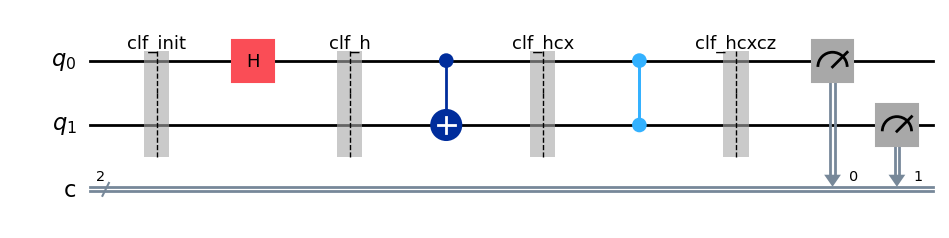

In [20]:
stab_simulator = AerSimulator(method='stabilizer')

n_qubits = 2
qc = QuantumCircuit(n_qubits, n_qubits)
qc.save_clifford(label='clf_init')
qc.h(0)
qc.save_clifford(label='clf_h')
qc.cx(0, 1)
qc.save_clifford(label='clf_hcx')
qc.cz(0, 1)
qc.save_clifford(label='clf_hcxcz')
qc.measure(range(n_qubits), range(n_qubits))
tcirc = transpile(qc, stab_simulator)
result = stab_simulator.run(tcirc).result()
qc.draw(output="mpl")

The stabilizer operators of initial state $|00\rangle$ are $I_2Z_1, Z_2I_1$, so binary table is represented as follows:

| |$x_1x_2$|$z_1z_2$|
|-|-|-|
|$Z_1I_2$|$00$|$10$|
|$I_1Z_2$|$00$|$01$|

In [21]:
result.data(0)['clf_init'].stab.astype(int)

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In the simulator, there is an additional column at the end of the table to handle the global phase.

By swaping the clomun between $x_1$ and $z_1$, 
we can see the quantum state after H gate is acted on 1st qubit. 

In [22]:
result.data(0)['clf_h'].stab.astype(int)

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Current stabilizer is $X_1I_2,I_1Z_2$, so current quantum state is $|0\rangle \otimes \frac{|0\rangle+|1\rangle}{\sqrt{2}}$. (Note that the right most qubit is 1st qubit)

We act CNOT gate on 1st qubit as control and 2nd qubit as target qubit. 
The binary table is updated by $x_2^{new}=x_1\oplus x_2, z_1^{new}=z_1\oplus z_2$.

In [23]:
result.data(0)['clf_hcx'].stab.astype(int)

array([[1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0]])

The stabilizer operator is $X_1X_2$ and $Z_1 Z_2$, so current quantum state is $\frac{|00\rangle+|11\rangle}{\sqrt{2}}$. 

We act CZ gate on 1st qubit as control qubit and 2nd qubit as target qubit. 

The bianry table is updated by $z_1^{new}=x_2\oplus z_1, z_2^{new}=x_1\oplus z_2$. 

In [24]:
result.data(0)['clf_hcxcz'].stab.astype(int)

array([[1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0]])

The stabilier operators are $Y_1Y_2, Z_1Z_2$, so current quantum state is $(|00\rangle-|11\rangle)/\sqrt{2}$. 

In [25]:
result.data(0)['counts']

{'0x3': 482, '0x0': 542}

Clifford gates also include single qubit gates whose rotation angle is $m\pi/2$, where $m$ is an integer.

# Comparing the execution time between state vector, MPS, and stabilizer simulator 
Here, we compare the execution time of generating GHZ states

In [26]:
statevec_simulator = AerSimulator(method='statevector')
stab_simulator = AerSimulator(method='stabilizer')
mps_simulator = AerSimulator(method='matrix_product_state')

def simulation(n_qubits, simulator):
    circ = QuantumCircuit(n_qubits, n_qubits)
    circ.h(0)
    for i in range (0, n_qubits-1):
        circ.cx(i, i+1)
    circ.measure(range(n_qubits), range(n_qubits))
    tcirc = transpile(circ, simulator)
    result = simulator.run(tcirc).result()
    return result.time_taken

nqubits_state_vec_list = [i for i in range(10,25,2)]
nqubits_mps_list = [i for i in range(10,61,5)]
nqubits_stab_list = [i for i in range(10,101,5)]
statevec_exec_time = [simulation(n_qubits, statevec_simulator) for n_qubits in nqubits_state_vec_list ]
mps_exec_time = [simulation(n_qubits, mps_simulator) for n_qubits in nqubits_mps_list]
stab_exec_time = [simulation(n_qubits, stab_simulator) for n_qubits in nqubits_stab_list]

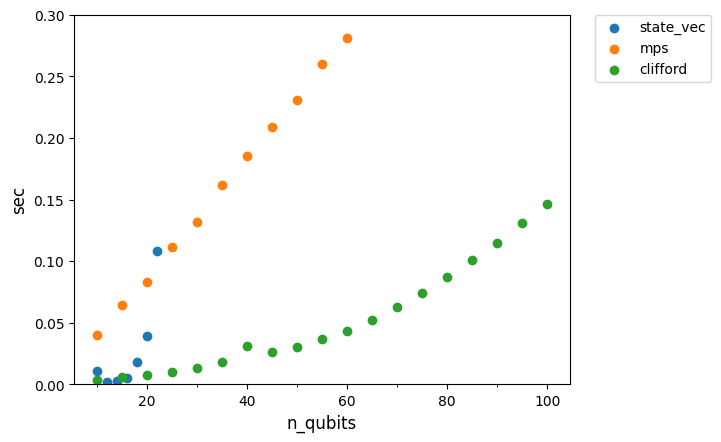

In [27]:
plt.scatter(nqubits_state_vec_list, statevec_exec_time, label="state_vec")
plt.scatter(nqubits_mps_list, mps_exec_time, label="mps")
plt.scatter(nqubits_stab_list, stab_exec_time, label="clifford")
plt.xlabel("n_qubits", fontsize=12)
plt.xticks(np.linspace(10,100,10),minor=True)
plt.ylabel("sec", fontsize=12)
plt.ylim(0,0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

The stabilizer simulator is fast and can simulate 100 qubits. 
The MPS simulator is slower than the stabilizer simulator, but can simulate 60 qubits. 
The state vector simulator is faster than the MPS simulator below 20 qubits (this depends on the cache size),
but the execution time and memory requirements increase exponentially above 20 qubits.

Here, we compare the simulation time of applying Ising Hamiltonian. 

$H=h \sum_{i=1}^n X_i + J \sum_{i=1}^n \sum_{j=1}^i Z_iZ_j$

Using Trotter decomposition,

$e^{-iH \Delta t} \simeq (\Pi_{j=1}^n e^{-i h X_j \Delta t})(\Pi_{j=1}^n \Pi_{k=1}^{j-1} e^{-i J Z_j Z_k \Delta t})$

We prepare the initial state as $|+\rangle^{\otimes n}$.

In [28]:
J = np.random.rand()
h = np.random.rand()

delta = 1e-3
def simulating_ising_model(n_qubits, simulator):
    qc = QuantumCircuit(n_qubits, n_qubits)
    # to prepare |+...+>
    for i in range(n_qubits):
        qc.h(i)
    # time-evolution by Ising Hamiltonian
    for i in range(n_qubits):
        qc.rx(-2*(-h*delta), i)
    for i in range(n_qubits):
        for j in range(i):
            qc.rzz(-2*(-J*delta), i, j)
    qc.measure(range(n_qubits), range(n_qubits))
    tcirc = transpile(qc, simulator)
    result = simulator.run(tcirc).result()
    return result.time_taken

nqubits_state_vec_list = [i for i in range(10,25,2)]
nqubits_mps_list = [i for i in range(10,61,5)]
statevec_exec_time = [simulating_ising_model(n_qubits, statevec_simulator) for n_qubits in nqubits_state_vec_list ]
mps_exec_time = [simulating_ising_model(n_qubits, mps_simulator) for n_qubits in nqubits_mps_list]

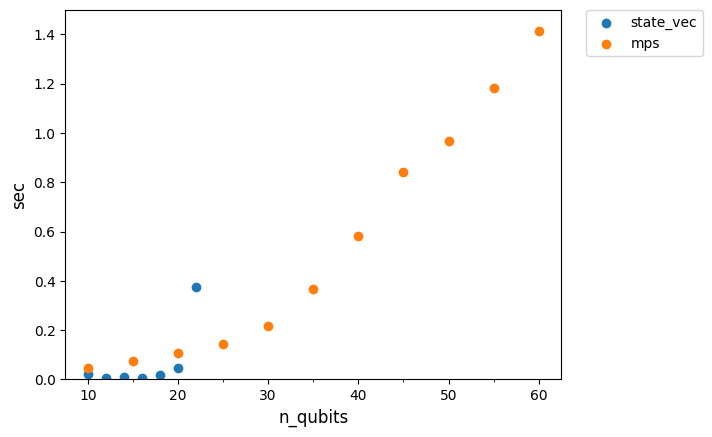

In [29]:
plt.scatter(nqubits_state_vec_list, statevec_exec_time, label="state_vec")
plt.scatter(nqubits_mps_list, mps_exec_time, label="mps")
plt.xlabel("n_qubits", fontsize=12)
plt.xticks(np.linspace(10,60,11),minor=True)
plt.ylabel("sec", fontsize=12)
plt.ylim(0,1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Similar to the previous result, matrix product state simulator allows us to simulate a larger system than state vector simulator. 

# Appendix: Example of Clifford Circuit
Here, we present the exmaples of Clifford circuit. First, we perform 

## Simultaneous Measurements

Here, we prepare a random quantum state and evaluate the expectation values using simultaneous measurements. 

In [30]:
angles = np.random.rand(6)*math.pi/2
def qc_exp():
    n_qubits = 2
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
    qc.u(angles[3], angles[4], angles[5], 1) # to prepare a random quantum state     
    observables = [SparsePauliOp(["XX"]),SparsePauliOp(["YY"]),SparsePauliOp(["ZZ"])]
    estimator = Estimator()
    job = estimator.run(circuits=[qc]*3, observables=observables)
    result = job.result().values
    return qc, result

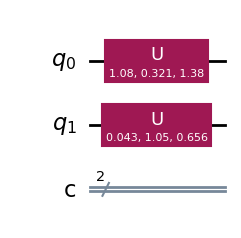

In [31]:
qc_sim1, result_sim1 = qc_exp()
qc_sim1.draw(output="mpl")

In [32]:
print("we've evaluated the expectation values: <psi|XX|psi>=", result_sim1[0], ", <psi|YY|psi>=", result_sim1[1], ", <psi|ZZ|psi>=", result_sim1[2])

we've evaluated the expectation values: <psi|XX|psi>= 0.017774195543390898 , <psi|YY|psi>= 0.010384181336040193 , <psi|ZZ|psi>= 0.4741138528411174


We add CNOT and H gates to the quantum circuit, and the observables are transformed into IZ, -ZZ, and ZI. 

In [33]:
def qc_simultaneous_measurement():
    n_qubits = 2
    qc = QuantumCircuit(n_qubits, n_qubits)
    qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state 
    qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state     
    qc.cx(0, 1)
    qc.h(0)
    # right most is 0th
    observables = [SparsePauliOp(["IZ"],coeffs=[1.0]),SparsePauliOp(["ZZ"],coeffs=[-1.0]),SparsePauliOp(["ZI"],coeffs=[1.0])]
    estimator = Estimator()
    job = estimator.run(circuits=[qc]*3, observables=observables)
    result = job.result().values
    return qc, result

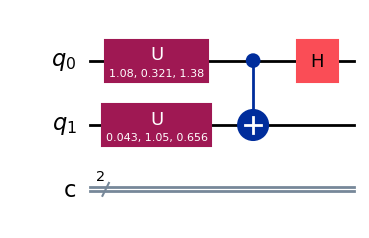

In [34]:
qc_sim2, result_sim2 = qc_simultaneous_measurement()
qc_sim2.draw(output="mpl")

We apply CNOT gate and H gate and evaluate the expectation values with $IZ$, $-ZZ$, $ZI$

In [35]:
print("we've evaluated the expectation values: <psi'|IZ|psi'>=", result_sim2[0], ", <psi'|-ZZ|psi'>=", result_sim2[1], ", <psi'|ZI|psi'>=", result_sim2[2])

we've evaluated the expectation values: <psi'|IZ|psi'>= 0.017774195543390825 , <psi'|-ZZ|psi'>= 0.010384181336040299 , <psi'|ZI|psi'>= 0.4741138528411173


These results are correspond to the previous results. 

Finally, we confirm that we've succeeded to perform simultaneous measurements to evaluate the expectation values using the result of sampling. 

In [36]:
n_qubits = 2
n_shots = 1e7
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # prepare a random quantum state 
qc.u(angles[3], angles[4], angles[5], 1) # prepare a random quantum state     
qc.cx(0, 1)
qc.h(0)

qc.measure(0,0)
qc.measure(1,1)

backend = AerSimulator()
result = backend.run(qc, shots=n_shots).result()
result_cnt = result.get_counts()
print(result_cnt)

{'11': 1243485, '00': 3704478, '10': 1384757, '01': 3667280}


If we describe a quantum state as $|\psi^\prime\rangle=a|00\rangle +b|01\rangle+c|10\rangle+d|11\rangle$, 

we can calculate the expectation values as follows:

$\langle \psi^\prime|I_1 Z_0|\psi^\prime\rangle = a^2-b^2+c^2-d^2$

$\langle \psi^\prime|Z_1 Z_0|\psi^\prime\rangle = a^2-b^2-c^2+d^2$

$\langle \psi^\prime|Z_1 I_0|\psi^\prime\rangle = a^2+b^2-c^2-d^2$

In [37]:
res_iz = result_cnt['00']-result_cnt['01']+result_cnt['10']-result_cnt['11']
res_zz = result_cnt['00']-result_cnt['01']-result_cnt['10']+result_cnt['11']
res_zi = result_cnt['00']+result_cnt['01']-result_cnt['10']-result_cnt['11']
print(res_iz/n_shots, -res_zz/n_shots, res_zi/n_shots)

0.017847 0.0104074 0.4743516


We have succeeded to evaluate the expectation values of $\langle \psi|XX|\psi \rangle$, $\langle \psi|YY|\psi \rangle$, and $\langle \psi|ZZ|\psi \rangle$.

These expectation values are good approximation of the exact expectation values described above.

From $XZ-ZX \neq O$, we can not simultaneously evaluate the expectation values of $\langle \psi|X|\psi \rangle$ and $\langle \psi|Z|\psi \rangle$. 

A simulator does not care about that, so ,first, we obtain the expectation values of $\langle \psi|X|\psi \rangle$ and $\langle \psi|Z|\psi \rangle$ by the following code. 

In [38]:
n_qubits = 1
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
observables = [SparsePauliOp(["X"]),SparsePauliOp(["Z"])]
estimator = Estimator()
job = estimator.run(circuits=[qc]*2, observables=observables)
result = job.result().values
print("<psi|X|psi>=", result[0], "<psi|Z|psi>=", result[1])

<psi|X|psi>= 0.8352228518884052 <psi|Z|psi>= 0.4745529242594718


In [39]:
n_qubits = 1 
n_shots = 1e6
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
qc.measure(0,0)

backend = AerSimulator()
result = backend.run(qc, shots=n_shots).result()
result_cnt = result.get_counts()
print(result_cnt)
print('<psi|Z|psi>=', (result_cnt['0']-result_cnt['1'])/n_shots)

{'1': 262356, '0': 737644}
<psi|Z|psi>= 0.475288


In [40]:
qc = QuantumCircuit(n_qubits, n_qubits)
qc.u(angles[0], angles[1], angles[2], 0) # to prepare a random quantum state 
qc.h(0) # add H gate
qc.measure(0,0)

backend = AerSimulator()
result = backend.run(qc, shots=n_shots).result()
result_cnt = result.get_counts()
print(result_cnt)
print('<psi|X|psi>=', (result_cnt['0']-result_cnt['1'])/n_shots)

{'1': 82592, '0': 917408}
<psi|X|psi>= 0.834816
